# Predicting Wildfire Spread Extent Given Ignitions
#### Fire Atlas Dataset
Andrew McDonald // CSE 847 // 6 March 2021

In [469]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

## 1. Explore Data

Let's see what our data has to offer, and consider how we may learn the ultimate size of the wildfire.

#### Load and Preview GeoDataframe

In [470]:
ignitions = gpd.read_file("2016_wildfires/usa_2016_ignitions.shp")
ignitions.head(5)

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,...,direction_,landcover,landcover_,tile_ID,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300,2016-11-02,307,8,...,east,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.41374 20.84379)
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302,2016-11-02,307,6,...,southeast,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.41833 20.83962)
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334,2016-11-29,334,1,...,none,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.43708 20.81045)
3,4,20.6271,-156.247,18.65,30.56,2016-02-16,47,2016-02-20,51,5,...,northwest,7,Open shrublands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.24786 20.62712)
4,5,19.8063,-155.895,7.72,12.96,2016-03-20,80,2016-03-25,85,6,...,southeast,7,Open shrublands,h03v07,326625791,North America,United States of America,USA,18560000.0,POINT (-155.89512 19.80629)


In [471]:
ignitions.shape

(11524, 24)

In [472]:
ignitions.columns


Index(['fire_ID', 'latitude', 'longitude', 'size', 'perimeter', 'start_date',
       'start_DOY', 'end_date', 'end_DOY', 'duration', 'expansion',
       'fire_line', 'speed', 'direction', 'direction_', 'landcover',
       'landcover_', 'tile_ID', 'pop_est', 'continent', 'name', 'iso_a3',
       'gdp_md_est', 'geometry'],
      dtype='object')

#### Set Predictors and Targets

In [473]:
X = ignitions[['latitude', 'longitude', 'start_DOY', 'expansion', 'speed', 'direction_', 'landcover_']]
y = ignitions[['size']]
X.shape, y.shape

((11524, 7), (11524, 1))

In [474]:
X.head()

,latitude,longitude,start_DOY,expansion,speed,direction_,landcover_
0,20.8438,-156.413,300,0.11,0.37,east,Croplands
1,20.8396,-156.418,302,0.25,0.57,southeast,Croplands
2,20.8105,-156.437,334,0.43,0.46,none,Croplands
3,20.6271,-156.247,47,3.73,2.68,northwest,Open shrublands
4,19.8063,-155.895,80,1.29,1.39,southeast,Open shrublands


In [475]:
y.head()

,size
0,0.86
1,1.50
2,0.43
3,18.65
4,7.72


#### Explore Target Distribution

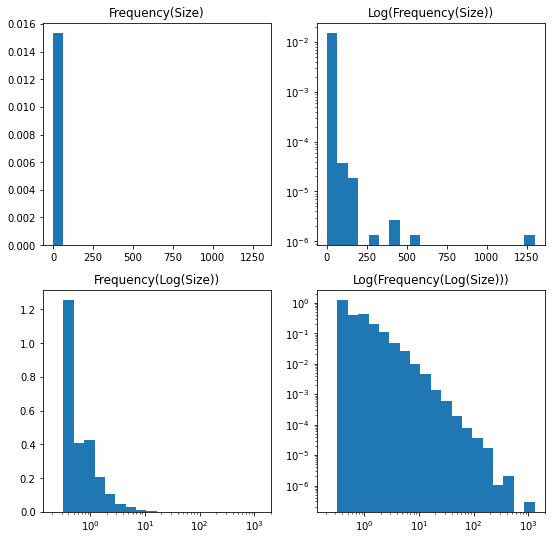

In [476]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
ax = ax.flatten()
n_bins = 20

# subplot 0: original frequency distribution of size
ax[0].hist(y, bins=n_bins, density=True)
ax[0].set_title("Frequency(Size)")

# subplot 1: log frequency distribution of size
ax[1].hist(y, log=True, bins=n_bins, density=True)
ax[1].set_title("Log(Frequency(Size))")

# subplot 2: frequency distribution of log size
hist, bins = np.histogram(y, bins=n_bins)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax[2].hist(y, bins=logbins, density=True)
ax[2].set_xscale('log')
ax[2].set_title("Frequency(Log(Size))")

# subplot 3: frequency distribution of log size
ax[3].hist(y, log=True, bins=logbins, density=True)
ax[3].set_xscale('log')
ax[3].set_title("Log(Frequency(Log(Size)))")

plt.show()

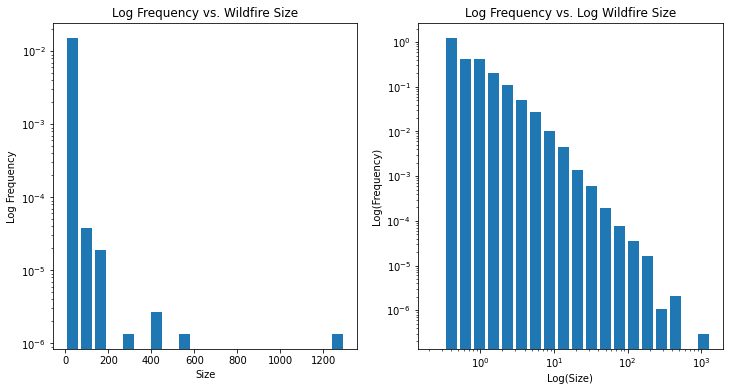

In [477]:
# plot figure for paper

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# subplot 0: frequency distribution of size
ax[0].hist(y, bins=n_bins, log=True, density=True, rwidth=0.8)
ax[0].set_title("Log Frequency vs. Wildfire Size")
ax[0].set_xlabel("Size")
ax[0].set_ylabel("Log Frequency")

# subplot 1: frequency distribution of log size
ax[1].hist(y, log=True, bins=logbins, density=True, rwidth=0.8)
ax[1].set_xscale('log')
ax[1].set_title("Log Frequency vs. Log Wildfire Size")
ax[1].set_xlabel("Log(Size)")
ax[1].set_ylabel("Log(Frequency)")

fig.suptitle("")

plt.savefig("midpoint/targets.png")
plt.show()

It appears there's a power law relationship between size and frequency, as exemplified by the relationship shown in the log-log plot. Recall the power-law pdf is given by

\begin{align}
p(x|a, \ell, s) = a \left( \frac{x-\ell}{s} \right)^{a-1}
\end{align}

where $\ell = loc$ and $s = scale$. Let's see how well it fits.

In [478]:
from scipy.stats import powerlaw
a, loc, scale = powerlaw.fit(y.values)
a, loc, scale

(0.047908108206211525, 0.20999999999999996, 1780.0558696755895)

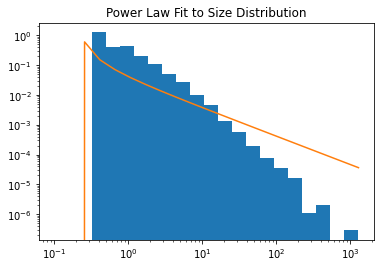

In [479]:
x = np.logspace(np.log10(0.1), np.log10(np.amax(y)), len(bins))
model_y = powerlaw.pdf(x, a, loc, scale)
fig, ax = plt.subplots()

ax.hist(y, log=True, bins=logbins, density=True)
ax.plot(x, model_y)
ax.set_xscale('log')
ax.set_title("Power Law Fit to Size Distribution")
plt.show()

Although the fit isn't perfect, this suggests we may wish to apply a logarithmic transformation to our size data to get more consistent results in terms of prediction.


#### Explore Feature Distributions

In [480]:
X.columns

Index(['latitude', 'longitude', 'start_DOY', 'expansion', 'speed',
       'direction_', 'landcover_'],
      dtype='object')

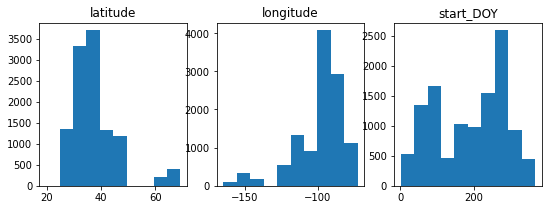

In [481]:
# visualize data without outliers
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, feature in enumerate(["latitude", "longitude", "start_DOY"]):
    ax[i].hist(X[feature].values)
    ax[i].set_title(feature)

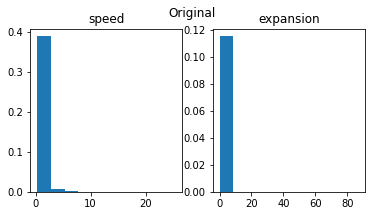

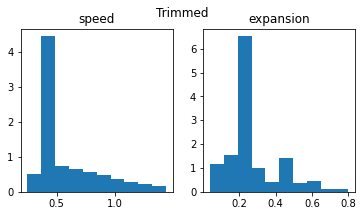

In [482]:
# visualize data with outliers
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Original")
for i, feature in enumerate(["speed", "expansion"]):
    ax[i].hist(X[feature].values, density=True)
    ax[i].set_title(feature)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Trimmed")
for i, feature in enumerate(["speed", "expansion"]):
    x = np.sort(X[feature].values)
    x = x[:int(0.9*len(x))]     # remove last 10% of tail
    ax[i].hist(x, density=True)
    ax[i].set_title(feature)


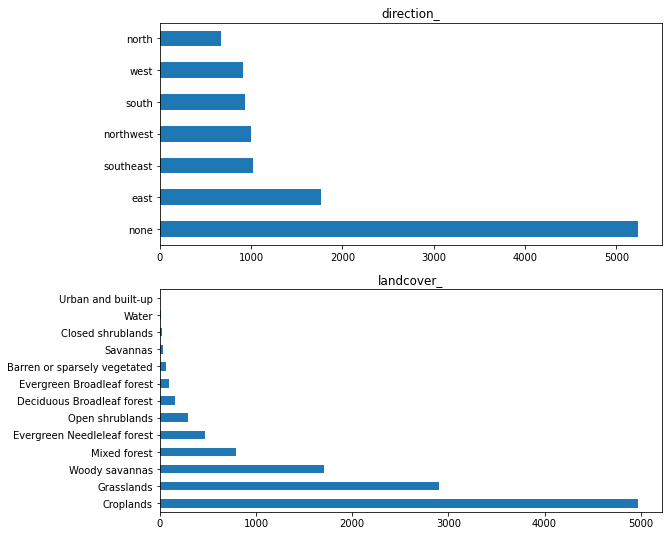

In [483]:
# visualize categorical data
fig, ax = plt.subplots(2, 1, figsize=(9, 9))
for i, feature in enumerate(["direction_", "landcover_"]):
    X[feature].value_counts().plot(ax=ax[i], kind="barh")
    ax[i].set_title(feature)
    # ax[i].tick_params(axis='x', labelrotation = 45)

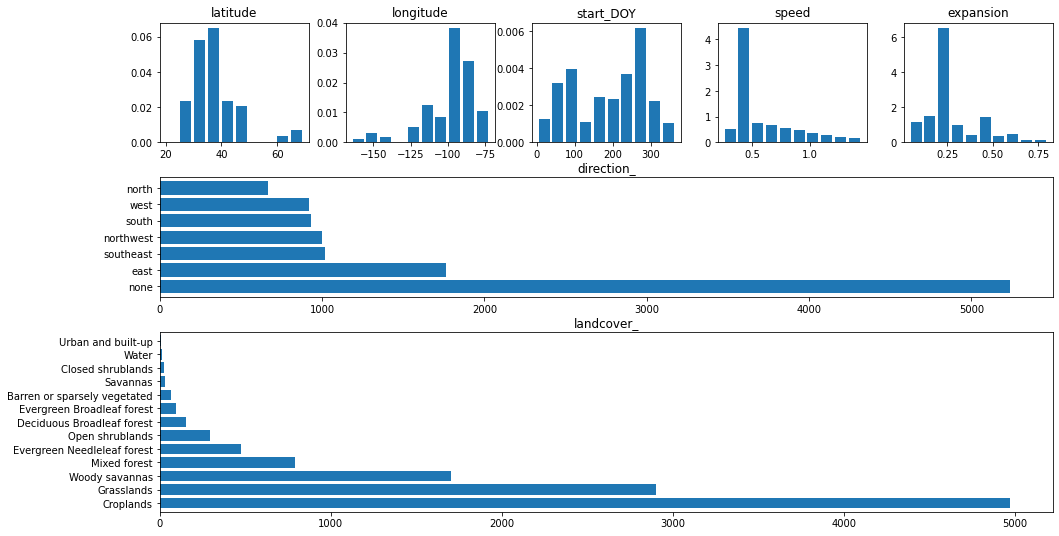

In [484]:
# plot in a single figure for paper
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(wspace=0.25, hspace=0.25)
spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig,
                         width_ratios=[1, 1, 1, 1, 1],
                         height_ratios=[1, 1, 1.5])

# store axes in a dict by keyword
axes = {}
axes["latitude"] = fig.add_subplot(spec[0, 0])
axes["longitude"] = fig.add_subplot(spec[0, 1])
axes["start_DOY"] = fig.add_subplot(spec[0, 2])
axes["speed"] = fig.add_subplot(spec[0, 3])
axes["expansion"] = fig.add_subplot(spec[0, 4])
axes["direction_"] = fig.add_subplot(spec[1, :])
axes["landcover_"] = fig.add_subplot(spec[2, :])

for i, feature in enumerate(["latitude", "longitude", "start_DOY"]):
    axes[feature].hist(X[feature].values, density=True, rwidth=0.8)
    axes[feature].set_title(feature)

for i, feature in enumerate(["speed", "expansion"]):
    x = np.sort(X[feature].values)
    x = x[:int(0.9*len(x))]     # remove last 10% of tail
    axes[feature].hist(x, density=True, rwidth=0.8)
    axes[feature].set_title(feature)

for i, feature in enumerate(["direction_", "landcover_"]):
    X[feature].value_counts().plot(ax=axes[feature], kind="barh", width=0.8)
    axes[feature].set_title(feature)

plt.savefig("midpoint/features.png")
plt.show()

## 2. Feature Engineering

In [485]:
X.columns

Index(['latitude', 'longitude', 'start_DOY', 'expansion', 'speed',
       'direction_', 'landcover_'],
      dtype='object')

What needs to be changed to make our data conducive to learning?
- As seen above, the columns `latitude`, `longitude`, `start_DOY` will simply need to be standardized.
- The `expansion` and `speed` columns needed outlier trimming for plotting, but likely won't need such trimming for modelling. Standardization should be enough.
- `direction_` and `landcover_` must be one-hot-encoded.
- We may wish to predict `y = size` on a logarithmic scale for more meaningful results.

#### Engineer Numeric Features

In [486]:
X_numeric = X[['latitude', 'longitude', 'start_DOY', 'expansion', 'speed']].values
X_numeric.shape, X_numeric[:5, :]

((11524, 5),
 array([[ 2.08438e+01, -1.56413e+02,  3.00000e+02,  1.10000e-01,
          3.70000e-01],
        [ 2.08396e+01, -1.56418e+02,  3.02000e+02,  2.50000e-01,
          5.70000e-01],
        [ 2.08105e+01, -1.56437e+02,  3.34000e+02,  4.30000e-01,
          4.60000e-01],
        [ 2.06271e+01, -1.56247e+02,  4.70000e+01,  3.73000e+00,
          2.68000e+00],
        [ 1.98063e+01, -1.55895e+02,  8.00000e+01,  1.29000e+00,
          1.39000e+00]]))

In [487]:
scaler = StandardScaler()
X_numeric_t = scaler.fit_transform(X_numeric)   # t stands for transformed
X_numeric_t.shape, X_numeric_t[:5, :]


((11524, 5),
 array([[-1.92468446, -3.45395302,  1.17087346, -0.2591936 , -0.5288488 ],
        [-1.92516891, -3.45425181,  1.19201114, -0.15498808, -0.27801056],
        [-1.92852545, -3.45538719,  1.53021409, -0.02100955, -0.41597159],
        [-1.94967973, -3.44403335, -1.50304362,  2.43526348,  2.36833282],
        [-2.04435491, -3.42299888, -1.15427183,  0.61911009,  0.7504262 ]]))

#### Engineer Categorical Features

In [488]:
lb_dir = LabelBinarizer()
encoded_direction = lb_dir.fit_transform(X["direction_"].values.reshape(-1, 1))
encoded_direction.shape, encoded_direction[:5, :]

((11524, 7),
 array([[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]]))

In [489]:
lb_land = LabelBinarizer()
encoded_land = lb_land.fit_transform(X["landcover_"].values.reshape(-1, 1))
encoded_land.shape, encoded_land[:5, :]

((11524, 13),
 array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]))

In [490]:
X_encoded_t = np.hstack((encoded_direction, encoded_land))
X_encoded_t.shape, X_encoded_t[:5, :]

((11524, 20),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]))

#### Combining Features

In [491]:
X_t = np.hstack((X_numeric_t, X_encoded_t))
X_t.shape, X_t[:2, :]

((11524, 25),
 array([[-1.92468446, -3.45395302,  1.17087346, -0.2591936 , -0.5288488 ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-1.92516891, -3.45425181,  1.19201114, -0.15498808, -0.27801056,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]))

#### Log-Scaling Targets

In [492]:
y.min(), y.max(), np.log(y.min()), np.log(y.max())

(size    0.21
 dtype: float64,
 size    1300.15
 dtype: float64,
 size   -1.560648
 dtype: float64,
 size    7.170235
 dtype: float64)

In [493]:
y_t = np.log(y.values).flatten()
y_t.shape, y_t[:5]

((11524,),
 array([-0.15082289,  0.40546511, -0.84397007,  2.92584615,  2.04381436]))

#### Preprocessing

In [494]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.3, shuffle=True, random_state=847)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8066, 25), (3458, 25), (8066,), (3458,))

## 4. Fit Linear Models

We'll begin with an unregularized model to build intuition, then proceed to perform cross-validation with $\ell_2$ and $\ell_1$ regularization.

#### Unregularized Model

In [495]:
# fit and investigate initial predictions
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat = lr.predict(X_test)

np.vstack((y_test[:10], y_hat[:10])).T

array([[ 0.25464222,  0.20088692],
       [-1.56064775, -1.42667303],
       [-0.4462871 ,  0.4086365 ],
       [-1.56064775, -1.45074791],
       [ 1.75613229,  1.49244228],
       [ 1.16938136,  0.40000999],
       [-1.56064775, -1.46628324],
       [ 0.06765865,  0.05290146],
       [-1.56064775, -1.51663172],
       [-0.84397007, -0.31617347]])

In [496]:
# investigate MSE and correlation
print(f"MSE = {mean_squared_error(y_test, y_hat)}")
print(f"R^2 = {pearsonr(y_test, y_hat)[0]}")
print(f"||W||_2 = {np.sqrt(np.sum(lr.coef_**2) + lr.intercept_**2)}")

MSE = 0.37528184982962104
R^2 = 0.8788287102028154
||W||_2 = 1.6051900476612255


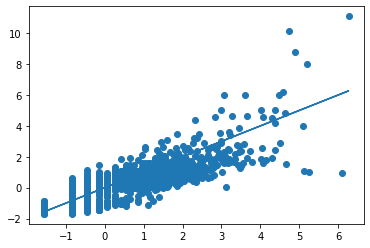

In [497]:
# save for later
y_hat_linreg = y_hat

# visualize predictions vs truth
plt.scatter(y_test, y_hat)
plt.plot(y_test, y_test)    # diagonal reference line

In [498]:
# investigate model coefficients
index = ["intercept"] + list(X.columns[:5]) + list(lb_dir.classes_) + list(lb_land.classes_)
weights = pd.DataFrame(np.append(lr.coef_, lr.intercept_), index=index, columns=["W"])
weights

,W
intercept,-0.070117
latitude,0.005596
longitude,-0.054238
start_DOY,-0.118023
expansion,0.744791
speed,0.114671
east,-1.156982
none,0.055333
north,0.335874
northwest,0.092069


#### $\ell_2$ Regularized Model

Next, we'll see how much our performance improves by using CV to choose and $\ell_2$ regularized model.

In [499]:
l2_log_lambdas = list(range(-5, 1)) + [i/5 + 1 for i in range(1, 11)]
l2_lambdas = [10**i for i in l2_log_lambdas]
l2_mse = []

for lamb in l2_lambdas:
    model = Ridge(alpha=lamb, random_state=847)
    kf = KFold(n_splits=5, shuffle=True, random_state=847)
    model_mse = []
    for train_index, val_index in kf.split(X_train):
        model.fit(X_train[train_index], y_train[train_index])
        y_hat = model.predict(X_train[val_index])
        model_mse.append(mean_squared_error(y_train[val_index], y_hat))
    l2_mse.append(np.mean(model_mse))

In [500]:
# find L2-optimal lambda
lambda_star = l2_lambdas[np.argmin(l2_mse)]
log_lambda_star = l2_log_lambdas[np.argmin(l2_mse)]
lambda_star_mse = np.amin(l2_mse)

print(f"L2-Optimal Lambda = 10**{log_lambda_star} = {lambda_star}")
print(f"Avg. Validation MSE = {lambda_star_mse}")

L2-Optimal Lambda = 10**1.8 = 63.09573444801933
Avg. Validation MSE = 0.41224324380028116


Text(0.5, 1.0, 'L2-Optimal $\\lambda$ Determined by 5-Fold CV')

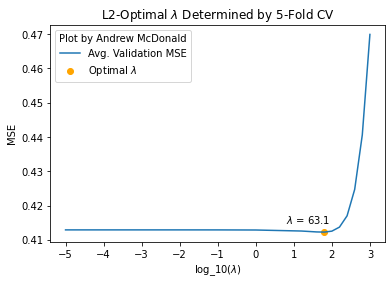

In [501]:
# visualize CV loss
plt.plot(l2_log_lambdas, l2_mse, label="Avg. Validation MSE")
plt.scatter(x=log_lambda_star, y=lambda_star_mse, c="orange", label="Optimal $\lambda$")
plt.text(x=log_lambda_star - 1, y=lambda_star_mse + 0.0025, s=f"$\lambda$ = {round(lambda_star, 2)}")
plt.legend(title="Plot by Andrew McDonald")
plt.xlabel("log_10($\lambda$)")
plt.ylabel("MSE")
plt.title("L2-Optimal $\lambda$ Determined by 5-Fold CV")

In [502]:
# evaluate on test set with lambda star
model = Ridge(alpha=lambda_star)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
np.vstack((y_test[:10], y_hat[:10])).T

array([[ 0.25464222,  0.19104195],
       [-1.56064775, -1.40848063],
       [-0.4462871 ,  0.36706576],
       [-1.56064775, -1.42888359],
       [ 1.75613229,  1.46147587],
       [ 1.16938136,  0.39207869],
       [-1.56064775, -1.44791634],
       [ 0.06765865,  0.04773431],
       [-1.56064775, -1.496269  ],
       [-0.84397007, -0.32331958]])

In [503]:
# investigate MSE and correlation
print(f"MSE = {mean_squared_error(y_test, y_hat)}")
print(f"R^2 = {pearsonr(y_test, y_hat)[0]}")
print(f"||W||_2 = {np.sqrt(np.sum(model.coef_**2) + model.intercept_**2)}")

MSE = 0.3749937999335881
R^2 = 0.8790314805377915
||W||_2 = 1.4970838926942973


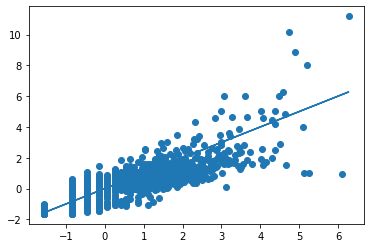

In [504]:
# save for later
y_hat_ridgereg = y_hat

# visualize predictions vs truth
plt.scatter(y_test, y_hat)
plt.plot(y_test, y_test)    # diagonal reference line

In [505]:
# investigate model coefficients
index = ["intercept"] + list(X.columns[:5]) + list(lb_dir.classes_) + list(lb_land.classes_)
weights = pd.DataFrame(np.append(model.coef_, model.intercept_), index=index, columns=["W"])
weights

,W
intercept,-0.070185
latitude,0.004704
longitude,-0.056252
start_DOY,-0.113001
expansion,0.742650
speed,0.120276
east,-1.126494
none,0.059392
north,0.317421
northwest,0.094252


#### $\ell_1$ Regularized Model

Finally, let's see how $\ell_1$ regularization compares.

In [506]:
l1_log_lambdas = [i/5 for i in range(-10, 1)]
l1_lambdas = [10**i for i in l1_log_lambdas]
l1_mse = []

for lamb in l1_lambdas:
    model = Lasso(alpha=lamb, max_iter=5000)
    kf = KFold(n_splits=5, shuffle=True, random_state=847)
    model_mse = []
    for train_index, val_index in kf.split(X_train):
        model.fit(X_train[train_index], y_train[train_index])
        y_hat = model.predict(X_train[val_index])
        model_mse.append(mean_squared_error(y_train[val_index], y_hat))
    l1_mse.append(np.mean(model_mse))

In [507]:
# find L1-optimal lambda
lambda_star = l1_lambdas[np.argmin(l1_mse)]
log_lambda_star = l1_log_lambdas[np.argmin(l1_mse)]
lambda_star_mse = np.amin(l1_mse)

print(f"Optimal Lambda = 10**{log_lambda_star} = {lambda_star}")
print(f"Avg. Validation MSE = {lambda_star_mse}")

Optimal Lambda = 10**-2.0 = 0.01
Avg. Validation MSE = 0.4085083103676463


Text(0.5, 1.0, 'L1-Optimal $\\lambda$ Determined by 5-Fold CV')

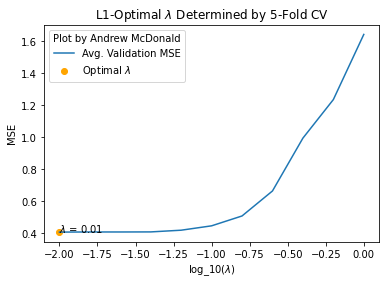

In [508]:
# visualize CV loss
plt.plot(l1_log_lambdas, l1_mse, label="Avg. Validation MSE")
plt.scatter(x=log_lambda_star, y=lambda_star_mse, c="orange", label="Optimal $\lambda$")
plt.text(x=log_lambda_star, y=lambda_star_mse, s=f"$\lambda$ = {round(lambda_star, 2)}")
plt.legend(title="Plot by Andrew McDonald")
plt.xlabel("log_10($\lambda$)")
plt.ylabel("MSE")
plt.title("L1-Optimal $\lambda$ Determined by 5-Fold CV")

In [509]:
# evaluate on test set with lambda star
model = Lasso(alpha=lambda_star)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

np.vstack((y_test[:10], y_hat[:10])).T

array([[ 0.25464222,  0.14167747],
       [-1.56064775, -1.39039059],
       [-0.4462871 ,  0.27462125],
       [-1.56064775, -1.38215139],
       [ 1.75613229,  1.36987275],
       [ 1.16938136,  0.46651005],
       [-1.56064775, -1.41833413],
       [ 0.06765865,  0.10137406],
       [-1.56064775, -1.44552349],
       [-0.84397007, -0.22805908]])

In [510]:
# investigate MSE and correlation
print(f"MSE = {mean_squared_error(y_test, y_hat)}")
print(f"R^2 = {pearsonr(y_test, y_hat)[0]}")
print(f"||W||_2 = {np.sqrt(np.sum(model.coef_**2) + model.intercept_**2)}")

MSE = 0.3746289913957143
R^2 = 0.8792903256490182
||W||_2 = 1.5079699445003965


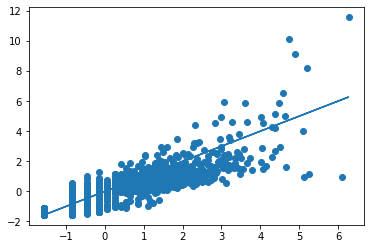

In [511]:
# save for later
y_hat_lassoreg = y_hat

# visualize predictions vs truth
plt.scatter(y_test, y_hat)
plt.plot(y_test, y_test)    # diagonal reference line

In [512]:
# investigate model coefficients
index = ["intercept"] + list(X.columns[:5]) + list(lb_dir.classes_) + list(lb_land.classes_)
weights = pd.DataFrame(np.append(model.coef_, model.intercept_), index=index, columns=["W"])
weights

,W
intercept,-0.053870
latitude,0.000000
longitude,-0.056407
start_DOY,-0.083515
expansion,0.723139
speed,-0.000000
east,-1.263880
none,-0.000000
north,0.103848
northwest,-0.000000


## 5. Fit Nonlinear Models

It looks like we could benefit from a more flexible model. Let's see if we can beat standard linear regression!

#### Kernel Ridge Regression

In [513]:
kr_log_lambdas = [i/5 for i in range(-20, 1)]
kr_lambdas = [10**i for i in kr_log_lambdas]
kr_mse = []

for lamb in kr_lambdas:
    model = KernelRidge(alpha=lamb, kernel="rbf")
    X_train_train, X_val, y_train_train, y_val = \
        train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=847)
    model.fit(X_train_train, y_train_train)
    y_hat = model.predict(X_val)
    kr_mse.append(mean_squared_error(y_val, y_hat))
    print(f"Lambda = {lamb}, MSE = {kr_mse[-1]}")

Lambda = 0.0001, MSE = 0.3083134123436325
Lambda = 0.00015848931924611142, MSE = 0.2732830884733613
Lambda = 0.00025118864315095795, MSE = 0.24378987543136899
Lambda = 0.00039810717055349735, MSE = 0.21983556684277303
Lambda = 0.000630957344480193, MSE = 0.20179995502696352
Lambda = 0.001, MSE = 0.18953165766537566
Lambda = 0.001584893192461114, MSE = 0.1821517608855731
Lambda = 0.0025118864315095794, MSE = 0.1783641106615682
Lambda = 0.003981071705534973, MSE = 0.17689297309222674
Lambda = 0.00630957344480193, MSE = 0.17674049666602104
Lambda = 0.01, MSE = 0.17722169642119384
Lambda = 0.015848931924611134, MSE = 0.1779268277367907
Lambda = 0.025118864315095794, MSE = 0.17871177048294176
Lambda = 0.039810717055349734, MSE = 0.1796635583394703
Lambda = 0.06309573444801933, MSE = 0.18097869319227922
Lambda = 0.1, MSE = 0.1828256048841347
Lambda = 0.15848931924611134, MSE = 0.18532155666705138
Lambda = 0.251188643150958, MSE = 0.18863206651698433
Lambda = 0.3981071705534972, MSE = 0.19306

In [514]:
# find KR-optimal lambda
lambda_star = kr_lambdas[np.argmin(kr_mse)]
log_lambda_star = kr_log_lambdas[np.argmin(kr_mse)]
lambda_star_mse = np.amin(kr_mse)

print(f"Optimal Lambda = 10**{log_lambda_star} = {lambda_star}")
print(f"Avg. Validation MSE = {lambda_star_mse}")

Optimal Lambda = 10**-2.2 = 0.00630957344480193
Avg. Validation MSE = 0.17674049666602104


Text(0.5, 1.0, 'KR-Optimal $\\lambda$ Determined by 5-Fold CV')

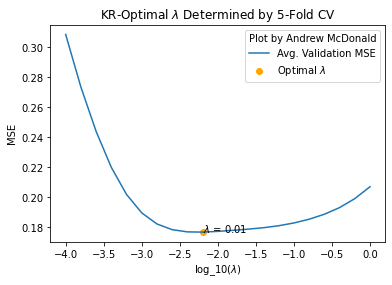

In [515]:
# visualize CV loss
plt.plot(kr_log_lambdas, kr_mse, label="Avg. Validation MSE")
plt.scatter(x=log_lambda_star, y=lambda_star_mse, c="orange", label="Optimal $\lambda$")
plt.text(x=log_lambda_star, y=lambda_star_mse, s=f"$\lambda$ = {round(lambda_star, 2)}")
plt.legend(title="Plot by Andrew McDonald")
plt.xlabel("log_10($\lambda$)")
plt.ylabel("MSE")
plt.title("KR-Optimal $\lambda$ Determined by 5-Fold CV")

In [516]:
# fit on train set with default params
model = KernelRidge(alpha=lambda_star, kernel="rbf")
model.fit(X_train, y_train)

# evaluate on test set with lambda star
y_hat = model.predict(X_test)
np.vstack((y_test[:10], y_hat[:10])).T

array([[ 0.25464222,  0.18167271],
       [-1.56064775, -1.56046417],
       [-0.4462871 , -0.50635179],
       [-1.56064775, -1.55360212],
       [ 1.75613229,  2.05950162],
       [ 1.16938136,  0.93870376],
       [-1.56064775, -1.47970806],
       [ 0.06765865,  0.27278884],
       [-1.56064775, -1.51117793],
       [-0.84397007, -0.65484591]])

In [517]:
# investigate MSE and correlation
print(f"MSE = {mean_squared_error(y_test, y_hat)}")
print(f"R^2 = {pearsonr(y_test, y_hat)[0]}")
# print(f"||W||_2 = {np.sqrt(np.sum(model.coef_**2) + model.intercept_**2)}")


MSE = 0.14454042126175443
R^2 = 0.9551595260236008


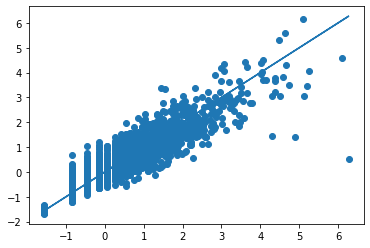

In [518]:
# save for later
y_hat_kernelreg = y_hat

# visualize predictions vs truth
plt.scatter(y_test, y_hat)
plt.plot(y_test, y_test)    # diagonal reference line

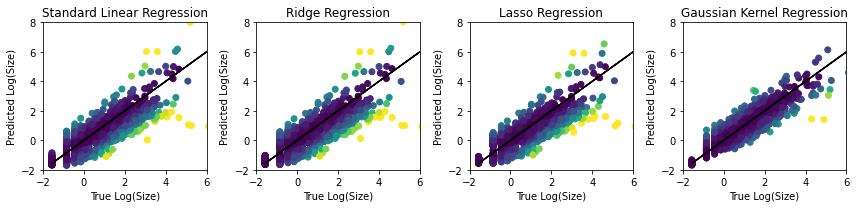

In [519]:
# plot results for paper

fig, ax = plt.subplots(1, 4, figsize=(12, 3))

ax[0].scatter(y_test, y_hat_linreg, c=(y_test - y_hat_linreg)**2, vmax=5)
ax[0].set_title("Standard Linear Regression")

ax[1].scatter(y_test, y_hat_ridgereg, c=(y_test - y_hat_ridgereg)**2, vmax=5)
ax[1].set_title("Ridge Regression")

ax[2].scatter(y_test, y_hat_lassoreg, c=(y_test - y_hat_lassoreg)**2, vmax=5)
ax[2].set_title("Lasso Regression")

ax[3].scatter(y_test, y_hat_kernelreg, c=(y_test - y_hat_kernelreg)**2, vmax=5)
ax[3].set_title("Gaussian Kernel Regression")

for i in range(4):
    ax[i].plot(y_test, y_test, c="k")   # reference line
    ax[i].set_xlabel("True Log(Size)")
    ax[i].set_ylabel("Predicted Log(Size)")
    ax[i].set_xlim((-2, 6))
    ax[i].set_ylim((-2, 8))

plt.tight_layout()
plt.savefig("midpoint/results.png")
plt.show()
